In [ ]:

import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline
import random
import math

In [ ]:
import torchvision
import torchvision.transforms as transforms

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)

Device available now: cuda


In [ ]:
image_transforms = transforms.Compose(
         [transforms.ToTensor(),
         transforms.CenterCrop(28),
         transforms.Normalize((0.5), (0.5))]
)

In [ ]:
batchsize = 32
rowsize = 28
colsize = 28
inchannels = 3
fc_size = 800
no_classes = 10
epochs = 30

In [ ]:

train_ioc = []
test_ioc = 0
train_nn = []
noise = 40
test_nn = 0

In [ ]:
class ciFAIR10(torchvision.datasets.CIFAR10):
    base_folder = 'ciFAIR-10'
    url = 'https://github.com/cvjena/cifair/releases/download/v1.0/ciFAIR-10.zip'
    filename = 'ciFAIR-10.zip'
    tgz_md5 = 'ca08fd390f0839693d3fc45c4e49585f'
    test_list = [
        ['test_batch', '01290e6b622a1977a000eff13650aca2'],
    ]

In [ ]:
train = ciFAIR10(root='./', train=True, download=True, transform=image_transforms)
test =  ciFAIR10(root='./', train=False, transform=image_transforms)

Files already downloaded and verified


In [ ]:
traindata = torch.utils.data.DataLoader(train,batch_size=batchsize, shuffle=True, num_workers=2,pin_memory=True)
testdata = torch.utils.data.DataLoader(test,batch_size=batchsize, shuffle=False, num_workers=2,pin_memory=True)

In [ ]:
class IOC_MLP(nn.Module):
  def __init__(self,rowsize,colsize,fc_size,inchannels,no_classes):
    super(IOC_MLP, self).__init__()
    self.fc1 = nn.Linear(rowsize*colsize*inchannels,fc_size)
    self.batchnorm1 = nn.BatchNorm1d(fc_size)
    self.fc2 = nn.Linear(fc_size,fc_size)
    self.batchnorm2 = nn.BatchNorm1d(fc_size)
    self.fc3 = nn.Linear(fc_size,fc_size)
    self.batchnorm3 = nn.BatchNorm1d(fc_size)
    self.fc4 = nn.Linear(fc_size,no_classes)


  def forward(self, x):
    x = torch.flatten(x,1)
    x = x.view(-1, rowsize*colsize*inchannels)
    x = F.elu(self.fc1(x))
    x = self.batchnorm1(x)
    x = F.elu(self.fc2(x))
    x = self.batchnorm2(x)
    x = F.elu(self.fc3(x))
    x = self.batchnorm3(x)
    return x

In [ ]:
class NN(nn.Module):
  def __init__(self,rowsize,colsize,fc_size,inchannels,no_classes):
    super(NN, self).__init__()
    self.fc1 = nn.Linear(rowsize*colsize*inchannels,fc_size)
    self.batchnorm1 = nn.BatchNorm1d(fc_size)
    self.fc2 = nn.Linear(fc_size,fc_size)
    self.batchnorm2 = nn.BatchNorm1d(fc_size)
    self.fc3 = nn.Linear(fc_size,fc_size)
    self.batchnorm3 = nn.BatchNorm1d(fc_size)
    self.fc4 = nn.Linear(fc_size,no_classes)


  def forward(self, x):
    x = torch.flatten(x,1)
    x = x.view(-1, rowsize*colsize*inchannels)
    x = F.relu(self.fc1(x))
    x = self.batchnorm1(x)
    x = F.relu(self.fc2(x))
    x = self.batchnorm2(x)
    x = F.relu(self.fc3(x))
    x = self.batchnorm3(x)
    return x

In [ ]:
ioc_model = IOC_MLP(rowsize,colsize,fc_size,inchannels,no_classes).to(device)
nn_model = NN(rowsize,colsize,fc_size,inchannels,no_classes).to(device)
# model = SimpleAlex(no_classes).to(device)

In [ ]:
ioc_optimizer = torch.optim.Adam(ioc_model.parameters(),lr= 0.0001)
nn_optimizer = torch.optim.Adam(nn_model.parameters(),lr= 0.0001)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:

for i in range(epochs):
  Loss = 0
  num_correct=0
  tot = 0
  for i,data in enumerate(traindata):
    # iterating through every batch
    x_data = data[0].to(device)
    labels = data[1].to(device)
    ioc_optimizer.zero_grad()
    outputs = ioc_model(x_data)
    _, pred = torch.max(outputs.data, 1)
    num_correct += (pred == labels).sum().item()
    tot += labels.size(0)
    loss = criterion(outputs, labels)
    loss.backward()
    ioc_optimizer.step()
    Loss += loss
    for w in ioc_model.parameters():
      p = w
      torch.where(w > 0, w, torch.exp(p))
  train_ioc.append(num_correct/tot)    
  print("Accuracy for exponentiation on negative weights : ",num_correct/tot)
  print("Loss for exponentiation on negative weights : ",loss.item())
  

Accuracy for exponentiation on negative weights :  0.34752
Loss for exponentiation on negative weights :  4.950436115264893
Accuracy for exponentiation on negative weights :  0.43078
Loss for exponentiation on negative weights :  4.339751720428467
Accuracy for exponentiation on negative weights :  0.46466
Loss for exponentiation on negative weights :  4.320328235626221
Accuracy for exponentiation on negative weights :  0.48566
Loss for exponentiation on negative weights :  3.621182680130005
Accuracy for exponentiation on negative weights :  0.50884
Loss for exponentiation on negative weights :  3.5815460681915283
Accuracy for exponentiation on negative weights :  0.52936
Loss for exponentiation on negative weights :  2.304992914199829
Accuracy for exponentiation on negative weights :  0.54684
Loss for exponentiation on negative weights :  2.5003459453582764
Accuracy for exponentiation on negative weights :  0.56072
Loss for exponentiation on negative weights :  2.0822558403015137
Accur

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testdata:
        images = images.to(device)
        labels = labels.to(device)
        outputs = ioc_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_ioc = correct/total
    print("Test Accuracy for exponentiation of weights for IOC Architecture : ",100 * correct / total)



Test Accuracy for exponentiation of weights for IOC Architecture :  50.22


In [ ]:

for i in range(epochs):
  Loss = 0
  num_correct=0
  tot = 0
  for i,data in enumerate(traindata):
    # iterating through every batch
    x_data = data[0].to(device)
    labels = data[1].to(device)
    nn_optimizer.zero_grad()
    outputs = nn_model(x_data)
    _, pred = torch.max(outputs.data, 1)
    num_correct += (pred == labels).sum().item()
    tot += labels.size(0)
    loss = criterion(outputs, labels)
    loss.backward()
    nn_optimizer.step()
    Loss += loss
  train_nn.append(num_correct/tot)    
  print("Accuracy for exponentiation on negative weights : ",num_correct/tot)
  print("Loss for exponentiation on negative weights : ",loss.item())
  

Accuracy for exponentiation on negative weights :  0.36844
Loss for exponentiation on negative weights :  2.510282039642334
Accuracy for exponentiation on negative weights :  0.44292
Loss for exponentiation on negative weights :  2.4704837799072266
Accuracy for exponentiation on negative weights :  0.47718
Loss for exponentiation on negative weights :  2.3494632244110107
Accuracy for exponentiation on negative weights :  0.50662
Loss for exponentiation on negative weights :  2.842975616455078
Accuracy for exponentiation on negative weights :  0.52768
Loss for exponentiation on negative weights :  1.8719474077224731
Accuracy for exponentiation on negative weights :  0.55222
Loss for exponentiation on negative weights :  2.534543514251709
Accuracy for exponentiation on negative weights :  0.5698
Loss for exponentiation on negative weights :  1.3578927516937256
Accuracy for exponentiation on negative weights :  0.591
Loss for exponentiation on negative weights :  0.4950754642486572
Accura

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testdata:
        images = images.to(device)
        labels = labels.to(device)
        outputs = nn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_nn = correct/total
    print("Test Accuracy for exponentiation of weights with NN Architecture : ",100 * correct / total)



Test Accuracy for exponentiation of weights with NN Architecture :  53.04


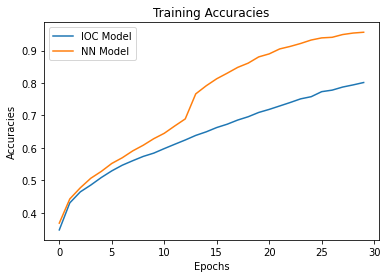

In [ ]:
import matplotlib.pyplot as plt
epoch_numbers = np.arange(0,epochs,1)
plt.title("Training Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.plot(epoch_numbers,train_ioc,label='IOC Model')
plt.plot(epoch_numbers,train_nn,label='NN Model')     
plt.legend()
plt.show()           

In [ ]:
print("Generalization Gap for NN Model",(train_nn[len(train_nn)-1]*100)-(test_nn*100))
print("Generalization Gap for IOC Model",(train_ioc[len(train_ioc)-1]*100)-(test_ioc*100))

Generalization Gap for NN Model 42.6
Generalization Gap for IOC Model 29.933999999999997
